In [1]:
import tensorly as tl
from tensorly import decomposition
import numpy as np
from qiskit import transpile, QuantumCircuit, quantum_info
from qiskit.providers.aer.backends import AerSimulator
from qclib.state_preparation import LowRankInitialize, BaaLowRankInitialize
from ncon import ncon
from qiskit.quantum_info import Statevector

backend = AerSimulator()

def to_state(vector):
    return vector / sum(abs(vector)) ** .5

def to_tensor(vector):
    n = int(np.log2(vector.size))
    return vector.reshape([2] * n)

# Equivalence check - `qclib`

In [2]:
one_vs_all = np.zeros((128,), dtype=np.float64)
one_vs_all[0] = 1
one_vs_all[-1] = 1
some_state = np.array([-1, 1])
one_vs_all = to_tensor(to_state(np.kron(some_state, one_vs_all)))
one_vs_all = tl.moveaxis(one_vs_all, list(range(8)), [1, 2, 3, 4, 0, 5, 6, 7])


two_vs_all = np.zeros((64,), dtype=np.float64)
two_vs_all[0] = 1
two_vs_all[-1] = 1
two_vs_all = to_tensor(to_state(np.kron(np.array([1, 1, 1, 1]), two_vs_all)))
two_vs_all = tl.moveaxis(two_vs_all, list(range(8)), [2, 0, 3, 4, 5, 1, 6, 7])

fully = np.ones((256,), dtype=np.float64)
fully[0] = 4
fully[-1] = 4
fully = to_tensor(to_state(fully))

disent = to_tensor(to_state(np.ones((256,), dtype=np.float64)))

np.random.seed(1)
randomstate = to_tensor(to_state(np.random.random((256,)) - .5))

In [3]:
def qclib_method(input_vector, loss=0.05, strategy='single_split'):
    return BaaLowRankInitialize(
                input_vector.reshape(-1), 
                opt_params={
                    "max_fidelity_loss": loss,
                    "strategy": strategy,
                })

def extract_subparts(circuit):
    unitaries = circuit.data
    groups = [sorted([qubit.register._size - qubit.index - 1 for qubit in uni[1]]) for uni in unitaries]
    return groups

In [4]:
def compare_circuit_to_state(circuit, state):
    circuit = transpile(circuit, backend)
    circuit.save_statevector()
    state_vector = backend.run(circuit).result().get_statevector()
    # fidelity by hands
    return abs(np.dot(state_vector, state.reshape(-1).conj())) ** 2


def report_qclib(state, statename="", loss=.05):
    print(f"\n==== {statename} ====")
    decomp = qclib_method(state, loss=loss, strategy='greedy')
    print("Greedy:", extract_subparts(decomp.definition))
    print(f"\tFidelity: {compare_circuit_to_state(decomp.definition, state)}")
    
    decomp = qclib_method(state, loss=loss, strategy='single_split')
    print("Single Split:", extract_subparts(decomp.definition))
    print(f"\tFidelity: {compare_circuit_to_state(decomp.definition, state)}")
    
    decomp = qclib_method(state, loss=loss, strategy='split')
    print("Split:", extract_subparts(decomp.definition))
    print(f"\tFidelity: {compare_circuit_to_state(decomp.definition, state)}")
    
    decomp = qclib_method(state, loss=loss, strategy='canonical')
    print("Canonical:", extract_subparts(decomp.definition))
    print(f"\tFidelity: {compare_circuit_to_state(decomp.definition, state)}")
          
    decomp = qclib_method(state, loss=loss, strategy='brute_force')
    print("Brute Force:", extract_subparts(decomp.definition))
    print(f"\tFidelity: {compare_circuit_to_state(decomp.definition, state)}")

In [5]:
report_qclib(one_vs_all, "One-vs-all")
report_qclib(two_vs_all, "two-vs-all")
report_qclib(fully, "Fully")
report_qclib(disent, "Disentangled")
report_qclib(randomstate, "Random")


==== One-vs-all ====
Greedy: [[0, 1, 2, 3, 4, 5, 6, 7]]


/var/folders/1g/92np41k92x9fz2f207vmq_ch0000gn/T/ipykernel_4458/515595509.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  groups = [sorted([qubit.register._size - qubit.index - 1 for qubit in uni[1]]) for uni in unitaries]


	Fidelity: 0.9999999999999991
Single Split: [[1], [0, 2, 3, 4, 5, 6, 7]]
	Fidelity: 0.9999999999999998
Split: [[0, 1, 2, 3, 4, 5, 6, 7]]
	Fidelity: 0.9999999999999991
Canonical: [[0, 1, 2, 3, 4, 5, 6, 7]]
	Fidelity: 0.9999999999999991
Brute Force: [[1], [0, 2, 3, 4, 5, 6, 7]]
	Fidelity: 0.9999999999999998

==== two-vs-all ====
Greedy: [[0, 1, 2, 3, 4, 5, 6, 7]]
	Fidelity: 0.9999999999999989
Single Split: [[0], [2], [1, 3, 4, 5, 6, 7]]
	Fidelity: 0.9999999999999996
Split: [[0, 1, 2, 3, 4, 5, 6, 7]]
	Fidelity: 0.9999999999999989
Canonical: [[0, 1, 2, 3, 4, 5, 6, 7]]
	Fidelity: 0.9999999999999989
Brute Force: [[0], [2], [1, 3, 4, 5, 6, 7]]
	Fidelity: 0.9999999999999996

==== Fully ====
Greedy: [[2], [3], [4], [5], [0], [1], [6], [7]]
	Fidelity: 1.0234374999999967
Single Split: [[2], [3], [4], [5], [0], [1], [6], [7]]
	Fidelity: 1.0234374999999967
Split: [[2], [3], [4], [5], [0], [1], [6], [7]]
	Fidelity: 1.0234374999999967
Canonical: [[2], [3], [4], [5], [0], [1], [6], [7]]
	Fidelity: 1.0

# Equivalence methods

In [6]:
def test_tensor_legs(T):
    # array legs contracted
    result = np.zeros((T.ndim,))

    plus = np.array([1, 1]) * .5 ** .5
    one = np.array([0, 1])

    c, m = decomposition.tucker(T, rank=T.shape)
    cabs = abs(c)
    mc = m.copy()
    
    for i in range(T.ndim):
        
        # for each mode i we will replace m[i] with I tensor
        # while for the others we will contract to |+>
        measurements = [plus] * T.ndim
        measurements[i] = one        
        tensors = [cabs] + measurements
        contractions = []
        # outgoing contractions of core tensor
        contractions.append(list(range(1, T.ndim + 1)))
        # measurements
        contractions += [[q] for q in contractions[0]]
        # hang a free leg
        result[i] = ncon(tensors, contractions)
    return result


def report_test_tensor(T, title=""):
    print(f"=== {title} ===")
    print([round(v, 5) for v in test_tensor_legs(T)])
    
    
def initialize_with_leg_cut(T, thresold):
    legs = test_tensor_legs(T)
    c, m = tl.decomposition.tucker(T, rank=T.shape)
    result = {}
    tensors = [c]
    contractions = [list(range(-1, -T.ndim-1, -1)), ]
        
    for i, leg in enumerate(legs):
        if leg < thresold:
            state = to_state(m[i][:, 0].reshape(2,))
            result[i] = state
            n = len(contractions)
            contractions[0][i] = n
            contractions += [[n]]
            tensors.append(state)

    if not result:
        return {-1: T.reshape(-1)}
            
    result[-1] = to_state(ncon(tensors, contractions).reshape(-1))
    return result


def get_leg_cut_circuit(T, threshold):
    qc = QuantumCircuit(T.ndim)
    result = initialize_with_leg_cut(T, threshold)
    other = set(range(T.ndim))    
    for key in result:
        if key != -1:
            qc.initialize(result[key] / np.linalg.norm(result[key]), 7 - key)
            other.remove(7 - key)
    if other:
        qc.initialize(result[-1] / np.linalg.norm(result[-1]), sorted(list(other)))
    return qc

In [7]:
report_test_tensor(one_vs_all, "One-vs-all")
report_test_tensor(two_vs_all, "two-vs-all")
report_test_tensor(fully, "Fully")
report_test_tensor(disent, "Disentangled")
report_test_tensor(randomstate, "Random")

=== One-vs-all ===
[0.0625, 0.0, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]
=== two-vs-all ===
[0.0, 0.0625, 0.0, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]
=== Fully ===
[0.13106, 0.13106, 0.13106, 0.13106, 0.13106, 0.13106, 0.13106, 0.13106]
=== Disentangled ===
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
=== Random ===
[0.32517, 0.32942, 0.32456, 0.33048, 0.3104, 0.32512, 0.33834, 0.32268]


In [8]:
initialize_with_leg_cut(to_tensor(disent), 0.001)

{0: array([-0.59460356, -0.59460356]),
 1: array([-0.59460356, -0.59460356]),
 2: array([-0.59460356, -0.59460356]),
 3: array([-0.59460356, -0.59460356]),
 4: array([-0.59460356, -0.59460356]),
 5: array([-0.59460356, -0.59460356]),
 6: array([-0.59460356, -0.59460356]),
 7: array([-0.59460356, -0.59460356]),
 -1: array([0.125])}

1.0
1.0916030534351124
1.0000000000000004


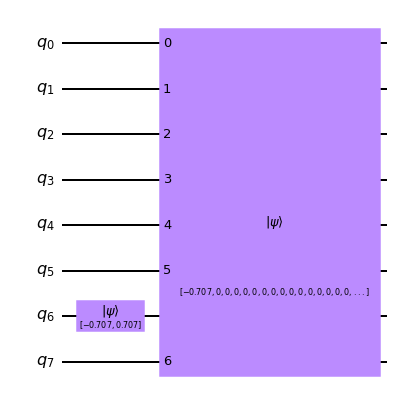

1.0


In [9]:
qc = get_leg_cut_circuit(disent, 0.001)
print(compare_circuit_to_state(qc, disent))

qc = get_leg_cut_circuit(fully, 0.001)
print(compare_circuit_to_state(qc, fully))

qc = get_leg_cut_circuit(one_vs_all, 0.001)
print(compare_circuit_to_state(qc, one_vs_all))
display(qc.draw(output='mpl'))

qc = get_leg_cut_circuit(two_vs_all, 0.001)
print(compare_circuit_to_state(qc, two_vs_all))

# Finally simple method

In [10]:
def get_singular_sum(tensor):
    import itertools
    from collections import Counter
    core, matrices = tl.decomposition.tucker(tensor, tensor.shape)
    result = np.zeros((tensor.ndim,))
    for index in itertools.product([0, 1], repeat=tensor.ndim):
        for i, v in enumerate(index):
            if v == 1: 
                result[i] += abs(core[index]) ** 2
    return result

def report_singular_sum(tensor):
    return str([round(x, 4) for x in get_singular_sum(tensor)])

In [11]:
print(report_singular_sum(one_vs_all), "One-vs-all")
print(report_singular_sum(two_vs_all), "two-vs-all")
print(report_singular_sum(fully), "Fully")
print(report_singular_sum(disent), "Disentangled")
print(report_singular_sum(randomstate), "Random")

[0.5, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5] One-vs-all
[0.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5] two-vs-all
[0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344] Fully
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Disentangled
[0.1585, 0.1675, 0.1537, 0.1613, 0.1518, 0.1649, 0.1699, 0.1637] Random
